In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)

df = pd.read_csv("hospital - hospital.csv")

print("Dataset Shape:", df.shape)
print("\nColumn Names:\n", df.columns.tolist())
print("\nPreview:\n", df.head())

missing = df.isnull().sum().sort_values(ascending=False)
print("\nMissing Values per Column:\n", missing.head(10))

df = df.copy()

df.columns = df.columns.str.strip()

df.dropna(axis=1, how='all', inplace=True);

target_col = 'Readmitted'
if target_col not in df.columns:
    raise ValueError(f"Expected target column '{target_col}' not found in dataset.")

df[target_col] = df[target_col].apply(lambda x: 1 if str(x).strip().lower() in ['yes', '1', 'true'] else 0)

plt.figure(figsize=(10,6))
dept_counts = df.groupby('Department')[target_col].sum().sort_values(ascending=False)
sns.barplot(x=dept_counts.index, y=dept_counts.values, palette="Blues_d")
plt.xticks(rotation=45, ha="right")
plt.title("Departments with Most Readmissions", fontsize=16, weight='bold')
plt.xlabel("Department")
plt.ylabel("Number of Readmissions")
plt.tight_layout()
plt.show()

X = df.drop(columns=[target_col])
y = df[target_col]

X = X.select_dtypes(include=[np.number])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train = X_train.replace([np.inf, -np.inf], np.nan)
X_test = X_test.replace([np.inf, -np.inf], np.nan)

imp = SimpleImputer(strategy="median")
X_train_imp = imp.fit_transform(X_train)
X_test_imp = imp.transform(X_test)

X_train_imp = np.nan_to_num(
    X_train_imp,
    nan=0.0,
    posinf=np.nanmax(X_train_imp[np.isfinite(X_train_imp)]),
    neginf=np.nanmin(X_train_imp[np.isfinite(X_train_imp)])
)
X_test_imp = np.nan_to_num(
    X_test_imp,
    nan=0.0,
    posinf=np.nanmax(X_test_imp[np.isfinite(X_test_imp)]),
    neginf=np.nanmin(X_test_imp[np.isfinite(X_test_imp)])
)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train_imp)
X_test_s = scaler.transform(X_test_imp)

print("Remaining inf in X_train:", np.isinf(X_train_s).sum())
print("Remaining inf in X_test:", np.isinf(X_test_s).sum())

logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train_s, y_train)

y_pred = logreg.predict(X_test_s)
y_prob = logreg.predict_proba(X_test_s)[:, 1]

print("\n=== Logistic Regression Performance ===")
print("Accuracy:", round(accuracy_score(y_test, y_pred), 4))
print("ROC-AUC:", round(roc_auc_score(y_test, y_prob), 4))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix", fontsize=14)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC={roc_auc_score(y_test, y_prob):.3f})")
plt.plot([0,1], [0,1], '--', color='gray')
plt.title("ROC Curve - Logistic Regression")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipython-input-2191663981.py", line 8, in <cell line: 0>
    from sklearn.impute import SimpleImputer
  File "/usr/local/lib/python3.12/dist-packages/sklearn/impute/__init__.py", line 9, in <module>
    from ._knn import KNNImputer
  File "/usr/local/lib/python3.12/dist-packages/sklearn/impute/_knn.py", line 11, in <module>
    from ..neighbors._base import _get_weights
  File "/usr/local/lib/python3.12/dist-packages/sklearn/neighbors/__init__.py", line 18, in <module>
    from ._nca import NeighborhoodComponentsAnalysis
  File "/usr/local/lib/python3.12/dist-packages/sklearn/neighbors/_nca.py", line 22, in <module>
    from ..decomposition import PCA
  File "/usr/local/lib/python3.12/dist-packages/sklearn/decomposition/__init__.py", line 11, in <module>
    from ._dict_learning imp

TypeError: object of type 'NoneType' has no len()

Correlation between Followup_Scheduled and Readmitted: -0.0720


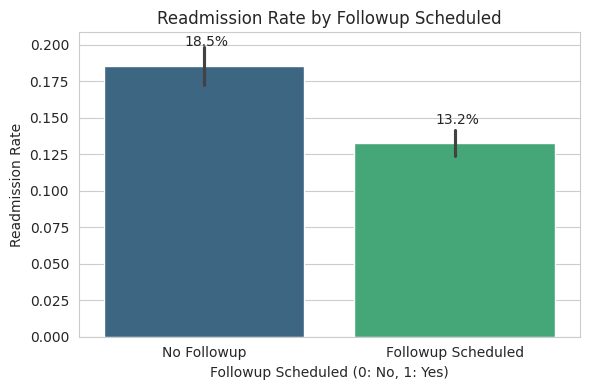

In [ ]:
correlation = df['Followup_Scheduled'].corr(df['Readmitted'])
print(f"Correlation between Followup_Scheduled and Readmitted: {correlation:.4f}")

plt.figure(figsize=(6, 4))
ax = sns.barplot(x='Followup_Scheduled', y='Readmitted', data=df, palette='viridis')
plt.title('Readmission Rate by Followup Scheduled')
plt.xlabel('Followup Scheduled (0: No, 1: Yes)')
plt.ylabel('Readmission Rate')
plt.xticks([0, 1], ['No Followup', 'Followup Scheduled'])
plt.tight_layout()

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.1%}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', xytext=(2, 12), textcoords='offset points')

plt.show()

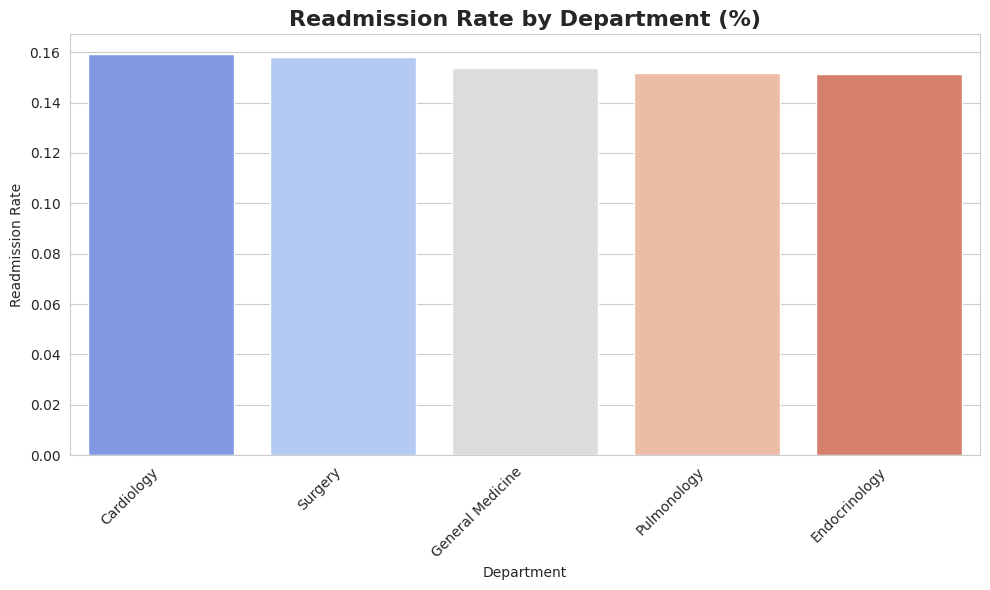

In [ ]:
dept_rate = (
    df.groupby('Department')[target_col]
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)

plt.figure(figsize=(10,6))
sns.barplot(data=dept_rate, x='Department', y=target_col, palette='coolwarm')
plt.title("Readmission Rate by Department (%)", fontsize=16, weight='bold')
plt.ylabel("Readmission Rate")
plt.xlabel("Department")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


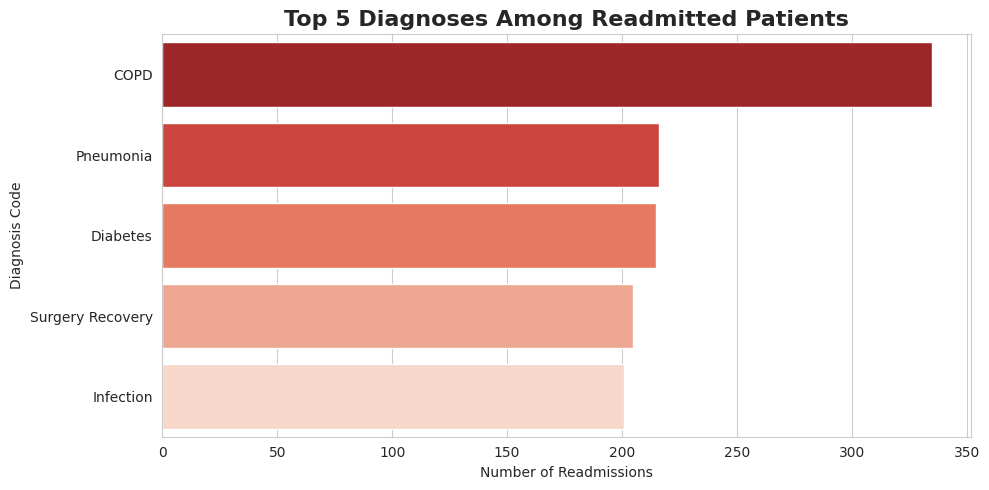

In [ ]:
if 'Primary_Diagnosis' in df.columns:
    diag_counts = (
        df[df[target_col] == 1]['Primary_Diagnosis']
        .value_counts()
        .head(5)
    )
    plt.figure(figsize=(10,5))
    sns.barplot(x=diag_counts.values, y=diag_counts.index, palette='Reds_r')
    plt.title("Top 5 Diagnoses Among Readmitted Patients", fontsize=16, weight='bold')
    plt.xlabel("Number of Readmissions")
    plt.ylabel("Diagnosis Code")
    plt.tight_layout()
    plt.show()


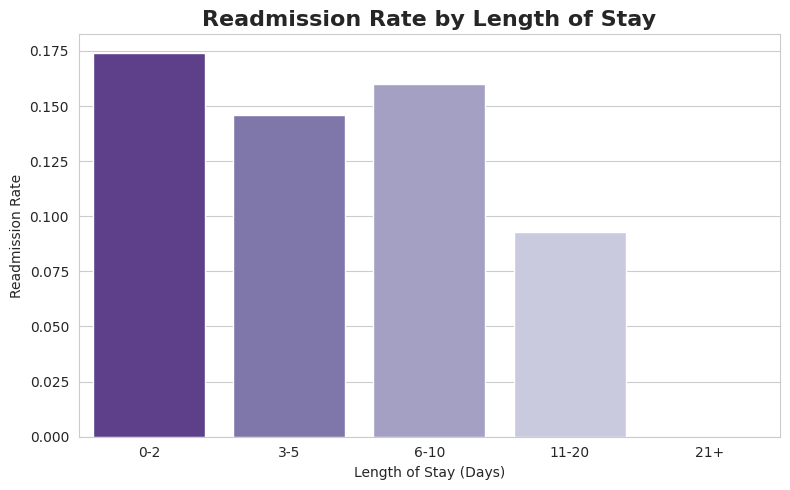

In [ ]:
if 'LOS' in df.columns:
    los_bins = pd.cut(df['LOS'], bins=[0,2,5,10,20,50], labels=['0-2','3-5','6-10','11-20','21+'])
    los_rate = df.groupby(los_bins)[target_col].mean().reset_index()

    plt.figure(figsize=(8,5))
    sns.barplot(data=los_rate, x='LOS', y=target_col, palette='Purples_r')
    plt.title("Readmission Rate by Length of Stay", fontsize=16, weight='bold')
    plt.ylabel("Readmission Rate")
    plt.xlabel("Length of Stay (Days)")
    plt.tight_layout()
    plt.show()


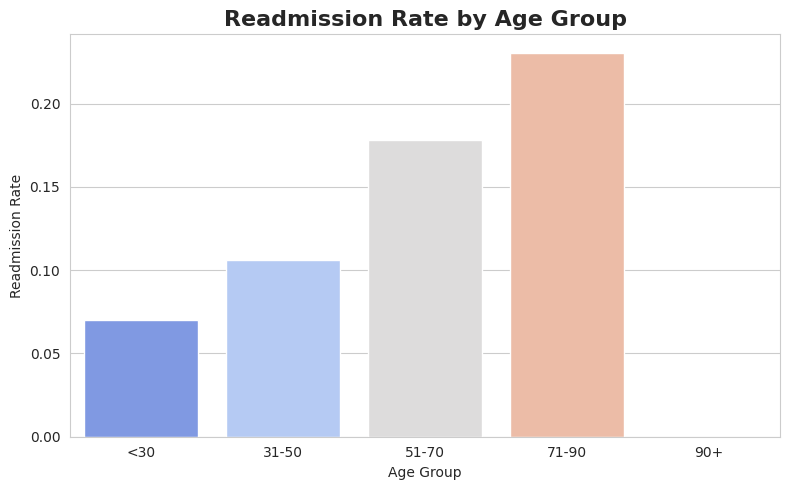

In [ ]:
if 'Age' in df.columns:
    age_bins = pd.cut(df['Age'], bins=[0,30,50,70,90,120], labels=['<30','31-50','51-70','71-90','90+'])
    age_rate = df.groupby(age_bins)[target_col].mean().reset_index()

    plt.figure(figsize=(8,5))
    sns.barplot(data=age_rate, x='Age', y=target_col, palette='coolwarm')
    plt.title("Readmission Rate by Age Group", fontsize=16, weight='bold')
    plt.ylabel("Readmission Rate")
    plt.xlabel("Age Group")
    plt.tight_layout()
    plt.show()


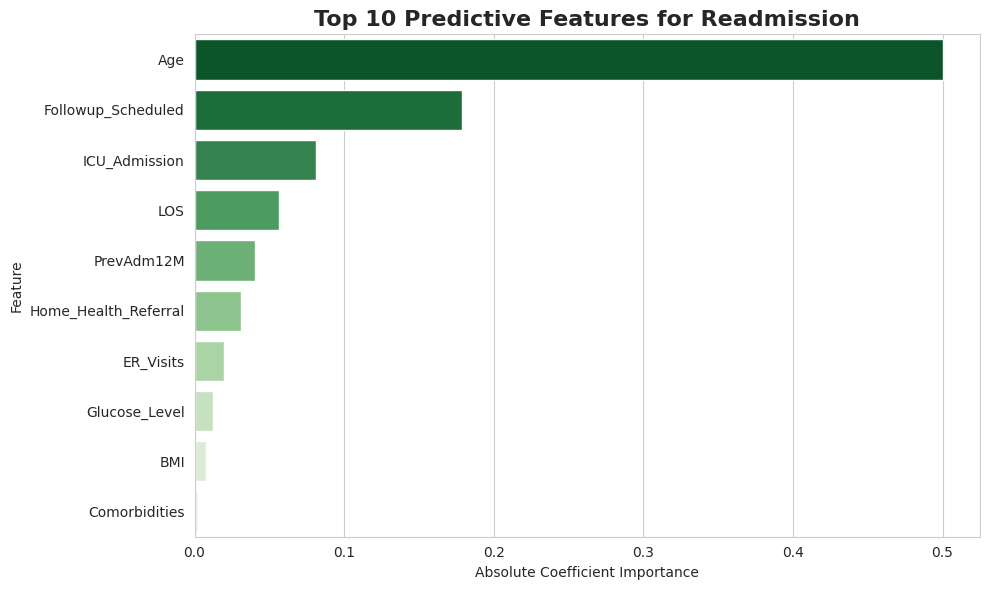

In [ ]:
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': np.abs(logreg.coef_[0])
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(data=feature_importance.head(10), x='Importance', y='Feature', palette='Greens_r')
plt.title("Top 10 Predictive Features for Readmission", fontsize=16, weight='bold')
plt.xlabel("Absolute Coefficient Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


✅ Data Loaded: (10000, 18) rows and columns

--- BASIC INFO ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Age                   10000 non-null  int64  
 1   Gender                10000 non-null  object 
 2   Insurance_Type        10000 non-null  object 
 3   Marital_Status        10000 non-null  object 
 4   Admission_Type        10000 non-null  object 
 5   Primary_Diagnosis     10000 non-null  object 
 6   Department            10000 non-null  object 
 7   BMI                   10000 non-null  float64
 8   Glucose_Level         9171 non-null   float64
 9   Comorbidities         10000 non-null  int64  
 10  ICU_Admission         10000 non-null  int64  
 11  Surgery               10000 non-null  int64  
 12  LOS                   9713 non-null   float64
 13  Followup_Scheduled    9496 non-null   float64
 14  Home_He

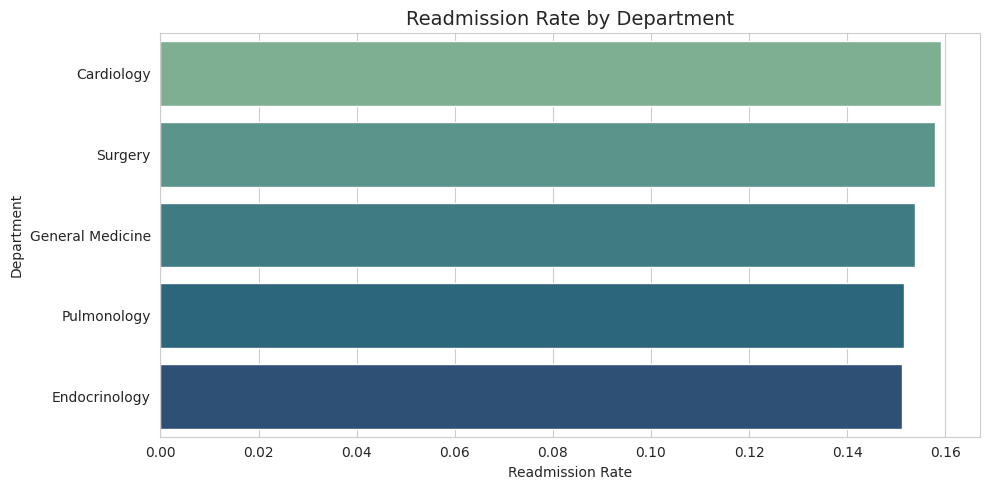

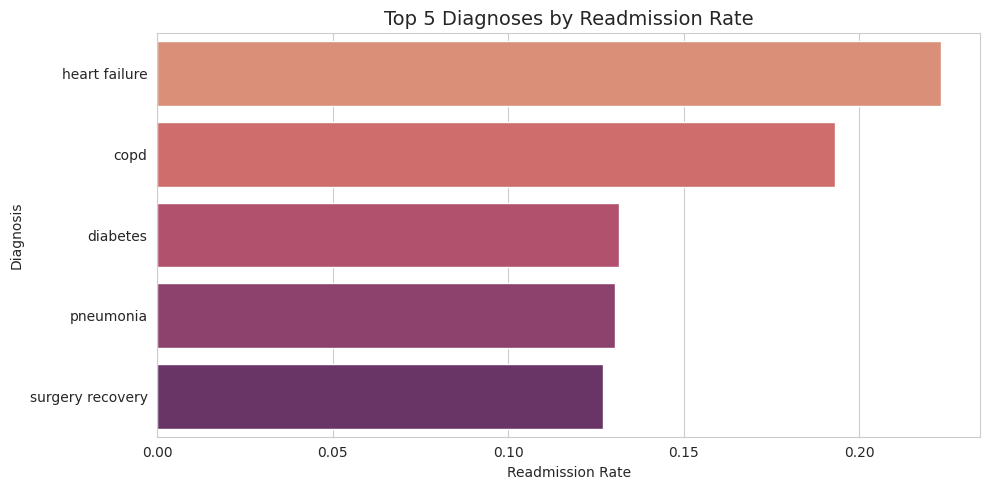

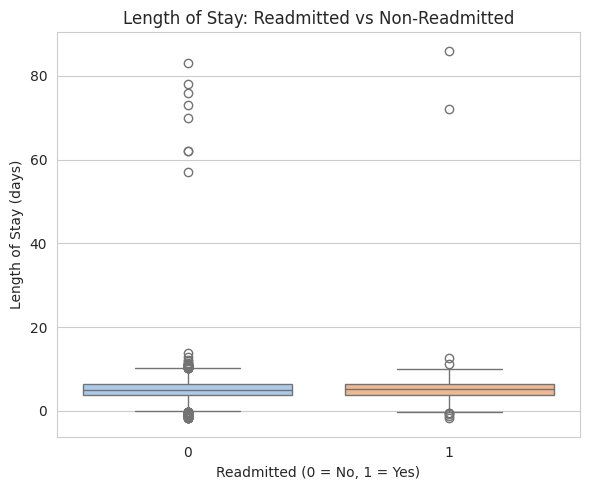

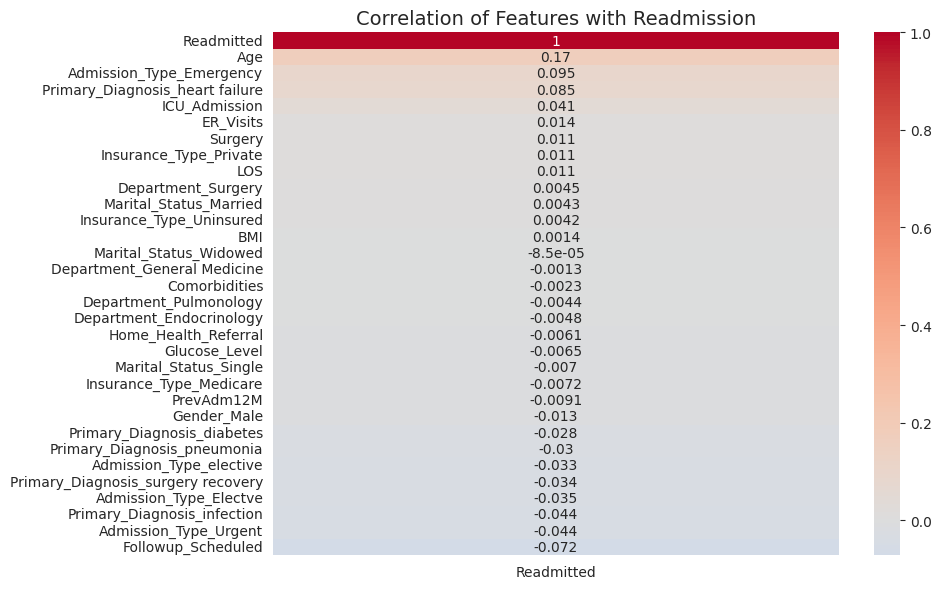


--- MODEL REPORT ---
              precision    recall  f1-score   support

           0       0.84      1.00      0.92      2110
           1       0.50      0.01      0.02       390

    accuracy                           0.84      2500
   macro avg       0.67      0.50      0.47      2500
weighted avg       0.79      0.84      0.77      2500



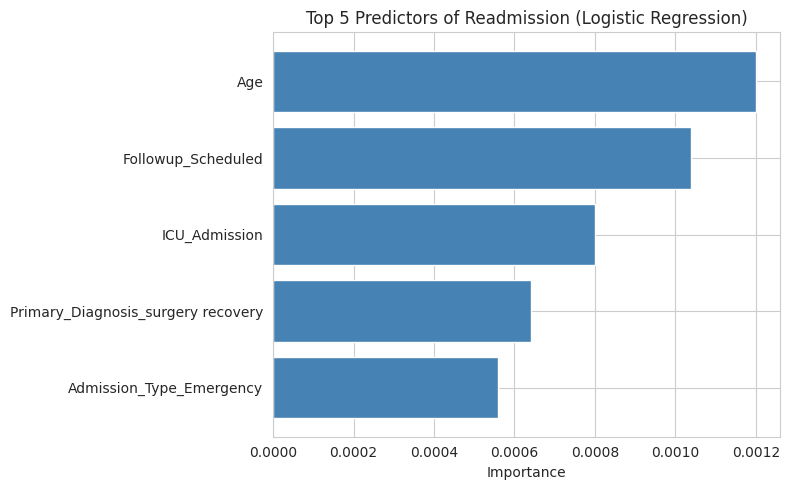

✅ Analysis Complete.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.inspection import permutation_importance

df = pd.read_csv("/content/hospital - hospital.csv")
print("Data Loaded:", df.shape, "rows and columns")

df = df.replace([np.inf, -np.inf], np.nan)

df = df.loc[:, df.isnull().mean() < 0.5]

cat_cols = df.select_dtypes(include="object").columns
df[cat_cols] = df[cat_cols].fillna("Unknown")

if 'Primary_Diagnosis' in df.columns:
    df['Primary_Diagnosis'] = df['Primary_Diagnosis'].str.lower()
    df['Primary_Diagnosis'] = df['Primary_Diagnosis'].replace('heartfailure', 'heart failure')


print("\nBASIC INFO")
print(df.info())

print("\nSUMMARY STATS")
print(df.describe())

print("\nMissing Values (%)")
print((df.isnull().mean() * 100).sort_values(ascending=False).head(10))

target_col = "Readmitted"
if target_col not in df.columns:
    raise ValueError("Target column 'readmitted' not found in dataset!")

plt.figure(figsize=(10, 5))
dept_counts = df.groupby("Department")[target_col].mean().sort_values(ascending=False)
sns.barplot(x=dept_counts.values, y=dept_counts.index, palette="crest")
plt.title("Readmission Rate by Department", fontsize=14)
plt.xlabel("Readmission Rate")
plt.ylabel("Department")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
diag_counts = df.groupby("Primary_Diagnosis")[target_col].mean().sort_values(ascending=False).head(5)
sns.barplot(x=diag_counts.values, y=diag_counts.index, palette="flare")
plt.title("Top 5 Diagnoses by Readmission Rate", fontsize=14)
plt.xlabel("Readmission Rate")
plt.ylabel("Diagnosis")
plt.tight_layout()
plt.show()

if "LOS" in df.columns:
    plt.figure(figsize=(6, 5))
    sns.boxplot(data=df, x=target_col, y="LOS", palette="pastel")
    plt.title("Length of Stay: Readmitted vs Non-Readmitted")
    plt.xlabel("Readmitted (0 = No, 1 = Yes)")
    plt.ylabel("Length of Stay (days)")
    plt.tight_layout()
    plt.show()

df_encoded = df.copy()
df_encoded = pd.get_dummies(df_encoded, drop_first=True)

plt.figure(figsize=(10, 6))
corr_matrix = df_encoded.corr(numeric_only=True)

sns.heatmap(
    corr_matrix[target_col].sort_values(ascending=False).to_frame(),
    annot=True, cmap="coolwarm", center=0
)
plt.title("Correlation of Features with Readmission", fontsize=14)
plt.tight_layout()
plt.show()

X = df_encoded.drop(columns=[target_col])
y = df_encoded[target_col]

X = X.replace([np.inf, -np.inf], np.nan)
imp = SimpleImputer(strategy="median")
X_imp = imp.fit_transform(X)
X_imp = np.nan_to_num(X_imp, nan=0.0)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imp)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=42)

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

print("\nMODEL REPORT")
print(classification_report(y_test, y_pred))

importances = permutation_importance(log_reg, X_test, y_test, n_repeats=5, random_state=42)
sorted_idx = importances.importances_mean.argsort()[-5:]

plt.figure(figsize=(8, 5))
plt.barh(np.array(X.columns)[sorted_idx], importances.importances_mean[sorted_idx], color="steelblue")
plt.title("Top 5 Predictors of Readmission (Logistic Regression)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

print("Analysis Complete.")

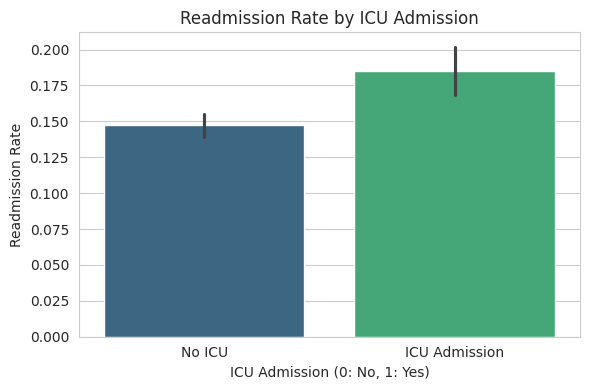

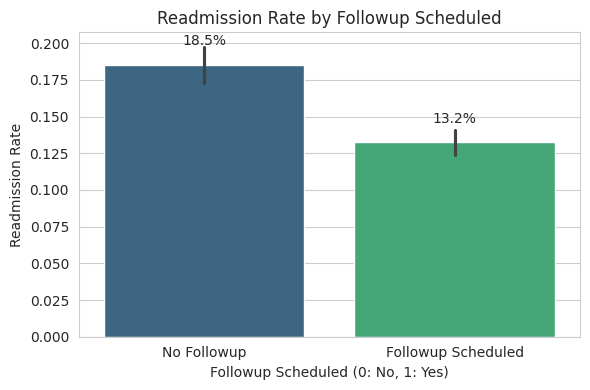

In [ ]:
# Analyze Readmission Rate by ICU Admission
plt.figure(figsize=(6, 4))
sns.barplot(x='ICU_Admission', y='Readmitted', data=df, palette='viridis')
plt.title('Readmission Rate by ICU Admission')
plt.xlabel('ICU Admission (0: No, 1: Yes)')
plt.ylabel('Readmission Rate')
plt.xticks([0, 1], ['No ICU', 'ICU Admission'])
plt.tight_layout()
plt.show()

# Analyze Readmission Rate by Followup Scheduled (already done, but can regenerate for context)
plt.figure(figsize=(6, 4))
ax = sns.barplot(x='Followup_Scheduled', y='Readmitted', data=df, palette='viridis')
plt.title('Readmission Rate by Followup Scheduled')
plt.xlabel('Followup Scheduled (0: No, 1: Yes)')
plt.ylabel('Readmission Rate')
plt.xticks([0, 1], ['No Followup', 'Followup Scheduled'])
plt.tight_layout()
# Add percentages on top of the bars
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.1%}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', xytext=(0, 12), textcoords='offset points')
plt.show()

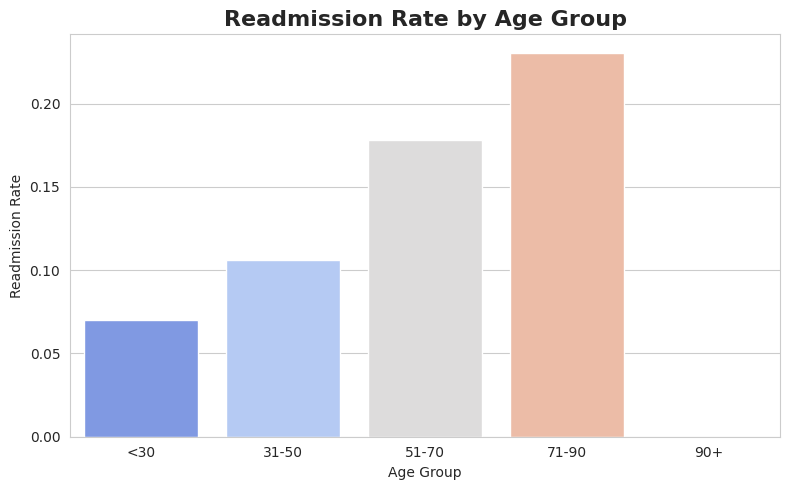

In [ ]:
if 'Age' in df.columns:
    age_bins = pd.cut(df['Age'], bins=[0,30,50,70,90,120], labels=['<30','31-50','51-70','71-90','90+'])
    age_rate = df.groupby(age_bins)['Readmitted'].mean().reset_index()

    plt.figure(figsize=(8,5))
    sns.barplot(data=age_rate, x='Age', y='Readmitted', palette='coolwarm')
    plt.title("Readmission Rate by Age Group", fontsize=16, weight='bold')
    plt.ylabel("Readmission Rate")
    plt.xlabel("Age Group")
    plt.tight_layout()
    plt.show()

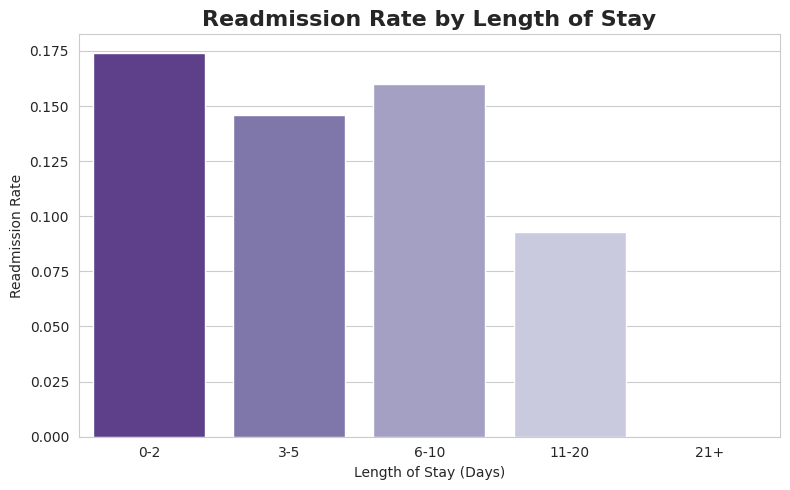

In [ ]:
if 'LOS' in df.columns:
    los_bins = pd.cut(df['LOS'], bins=[0,2,5,10,20,50], labels=['0-2','3-5','6-10','11-20','21+'])
    los_rate = df.groupby(los_bins)['Readmitted'].mean().reset_index()

    plt.figure(figsize=(8,5))
    sns.barplot(data=los_rate, x='LOS', y='Readmitted', palette='Purples_r')
    plt.title("Readmission Rate by Length of Stay", fontsize=16, weight='bold')
    plt.ylabel("Readmission Rate")
    plt.xlabel("Length of Stay (Days)")
    plt.tight_layout()
    plt.show()

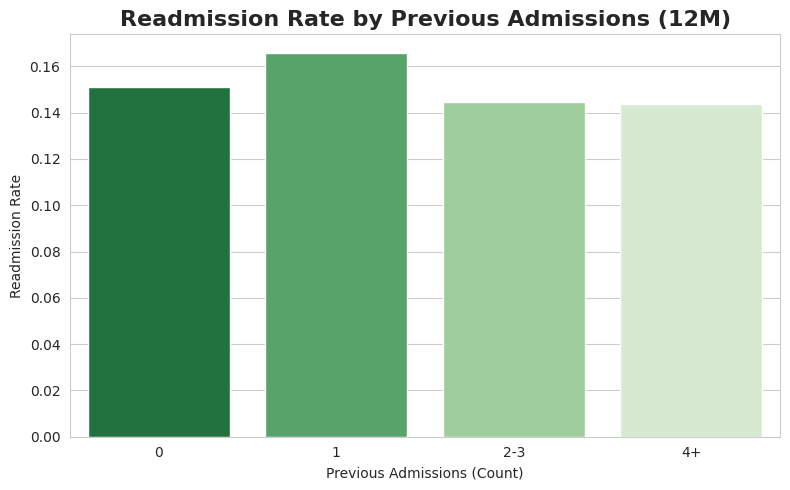

In [ ]:
if 'PrevAdm12M' in df.columns:
    prev_adm_bins = pd.cut(df['PrevAdm12M'], bins=[-1, 0, 1, 3, 10], labels=['0', '1', '2-3', '4+']) # Adjust bins as needed
    prev_adm_rate = df.groupby(prev_adm_bins)['Readmitted'].mean().reset_index()

    plt.figure(figsize=(8,5))
    sns.barplot(data=prev_adm_rate, x='PrevAdm12M', y='Readmitted', palette='Greens_r')
    plt.title("Readmission Rate by Previous Admissions (12M)", fontsize=16, weight='bold')
    plt.ylabel("Readmission Rate")
    plt.xlabel("Previous Admissions (Count)")
    plt.tight_layout()
    plt.show()

In [ ]:
# =====================================================================
# HOSPITAL READMISSION BASELINE PIPELINE — CLEAN + ROBUST VERSION
# =====================================================================

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# ==============================================================
# 1. Load dataset
# ==============================================================

csv_path = "/content/hospital - hospital.csv"
print("Loading:", csv_path)
df = pd.read_csv(csv_path)
print("\n=== HEAD ===")
display(df.head())
print("\n=== DTYPE ===")
print(df.dtypes)
print("\nNumber of rows:", len(df))
print("Number of columns:", len(df.columns))

# ==============================================================
# 2. Infer key columns
# ==============================================================

cols = [c.lower() for c in df.columns]
patient_cols = [c for c in df.columns if any(x in c.lower() for x in ["patient_id", "mrn", "patient", "pid", "id"])]
admit_cols = [c for c in df.columns if any(x in c.lower() for x in ["admit", "admission", "adm_date", "arrival"])]
disch_cols = [c for c in df.columns if any(x in c.lower() for x in ["discharge", "disch", "disposition", "dis_date"])]
target_cols = [c for c in df.columns if any(x in c.lower() for x in ["readmit", "readmission", "readmitted", "30day", "30_day", "30_day_readmit", "readmit_30"])]

print("\nCandidate patient id columns:", patient_cols)
print("Candidate admission date columns:", admit_cols)
print("Candidate discharge date columns:", disch_cols)
print("Candidate target columns:", target_cols)

patient_col = patient_cols[0] if patient_cols else None
admit_col = admit_cols[0] if admit_cols else None
disch_col = disch_cols[0] if disch_cols else None
target_col = target_cols[0] if target_cols else None

if admit_col:
    try:
        df[admit_col] = pd.to_datetime(df[admit_col])
    except Exception as e:
        print(f"Could not convert admit col {admit_col} to datetime:", e)
if disch_col:
    try:
        df[disch_col] = pd.to_datetime(df[disch_col])
    except Exception as e:
        print(f"Could not convert discharge col {disch_col} to datetime:", e)

print("\nInferred columns used for baseline:")
print("patient_col:", patient_col)
print("admit_col:", admit_col)
print("disch_col:", disch_col)
print("target_col:", target_col)

if admit_col:
    print("Time range:", df[admit_col].min(), "to", df[admit_col].max())
if patient_col:
    print("Unique patients:", df[patient_col].nunique())

if target_col:
    print("\nTarget value counts:")
    print(df[target_col].value_counts(dropna=False))
    unique_vals = df[target_col].dropna().unique()
    print("Unique target values sample:", unique_vals[:10])

# ==============================================================
# 3. Prepare numeric features
# ==============================================================

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if patient_col and patient_col in numeric_cols:
    numeric_cols.remove(patient_col)
if target_col and target_col in numeric_cols:
    numeric_cols.remove(target_col)
print("\nNumeric columns considered for baseline:", numeric_cols)

if not target_col:
    print("\nNo obvious target column found. Please check target column names. Suggestions:")
    print(["readmit", "readmission", "readmitted", "30_day", "readmit_30", "readmission_within_30_days"])
else:
    # ==============================================================
    # 4. Time-based train/test split
    # ==============================================================

    df_sorted = df.sort_values(by=admit_col) if admit_col else df.copy()
    n = len(df_sorted)
    cutoff = int(n * 0.8)
    train_df = df_sorted.iloc[:cutoff].copy()
    test_df = df_sorted.iloc[cutoff:].copy()
    print(f"\nTrain rows: {len(train_df)}, Test rows: {len(test_df)} (chronological split)")

    if patient_col:
        overlap = set(train_df[patient_col]).intersection(set(test_df[patient_col]))
        if overlap:
            print(f"Found {len(overlap)} patients in both splits. Enforcing patient-level split.")
            first_admit = df.groupby(patient_col)[admit_col].min().reset_index()
            first_admit = first_admit.sort_values(by=admit_col)
            patient_cutoff = int(len(first_admit) * 0.8)
            train_patients = set(first_admit.iloc[:patient_cutoff][patient_col])
            train_df = df[df[patient_col].isin(train_patients)].copy()
            test_df = df[~df[patient_col].isin(train_patients)].copy()
            print(f"After patient-based split -> Train rows: {len(train_df)}, Test rows: {len(test_df)}")

    # ==============================================================
    # 5. Prepare feature matrices
    # ==============================================================

    train_df = train_df.dropna(subset=[target_col])
    test_df = test_df.dropna(subset=[target_col])
    X_train = train_df[numeric_cols].copy()
    X_test = test_df[numeric_cols].copy()
    y_train = train_df[target_col].astype(int)
    y_test = test_df[target_col].astype(int)

    # ==============================================================
    # 6. Clean + impute + scale (THIS IS THE UPDATED FIX)
    # ==============================================================

    print("\nCleaning data: replacing infinities, imputing missing, scaling...")

    # Replace any infinite values with NaN
    X_train = X_train.replace([np.inf, -np.inf], np.nan)
    X_test = X_test.replace([np.inf, -np.inf], np.nan)

    # Impute missing values (including those replaced from inf)
    imp = SimpleImputer(strategy="median")
    X_train_imp = imp.fit_transform(X_train)
    X_test_imp = imp.transform(X_test)

    # Replace any remaining inf or NaN after imputation (safety net)
    X_train_imp = np.nan_to_num(
        X_train_imp,
        nan=0.0,
        posinf=np.nanmax(X_train_imp[np.isfinite(X_train_imp)]),
        neginf=np.nanmin(X_train_imp[np.isfinite(X_train_imp)])
    )
    X_test_imp = np.nan_to_num(
        X_test_imp,
        nan=0.0,
        posinf=np.nanmax(X_test_imp[np.isfinite(X_test_imp)]),
        neginf=np.nanmin(X_test_imp[np.isfinite(X_test_imp)])
    )

    # Scale after imputation
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train_imp)
    X_test_s = scaler.transform(X_test_imp)

    # Optional diagnostic check
    print("Remaining inf in X_train:", np.isinf(X_train_s).sum())
    print("Remaining inf in X_test:", np.isinf(X_test_s).sum())

    # ==============================================================
    # 7. Logistic Regression baseline model
    # ==============================================================

    clf = LogisticRegression(max_iter=1000, solver="saga")
    clf.fit(X_train_s, y_train)
    prob_test = clf.predict_proba(X_test_s)[:, 1]

    auroc = roc_auc_score(y_test, prob_test)
    auprc = average_precision_score(y_test, prob_test)
    brier = brier_score_loss(y_test, prob_test)
    print(f"\nBaseline Logistic Regression results on holdout:")
    print(f"AUROC: {auroc:.4f}")
    print(f"AUPRC: {auprc:.4f}")
    print(f"Brier score: {brier:.4f}")

    coef = clf.coef_[0]
    feat_coef = pd.DataFrame({"feature": numeric_cols, "coef": coef})
    feat_coef = feat_coef.assign(abs_coef=feat_coef.coef.abs()).sort_values("abs_coef", ascending=False).head(20)
    print("\nTop coefficients (absolute value):")
    display(feat_coef)

print("\n--- End of quick baseline diagnostics ---")


Loading: /content/hospital - hospital.csv

=== HEAD ===


,Age,Gender,Insurance_Type,Marital_Status,Admission_Type,Primary_Diagnosis,Department,BMI,Glucose_Level,Comorbidities,ICU_Admission,Surgery,LOS,Followup_Scheduled,Home_Health_Referral,PrevAdm12M,ER_Visits,Readmitted
0,71,Male,Medicaid,Married,Electve,Pneumonia,Surgery,17.6,107.9,1,1,0,0.9,0.0,0.0,0,2,0
1,34,Female,Medicare,Widowed,Emergency,Heart Failure,General Medicine,28.1,93.4,2,0,0,6.7,1.0,1.0,1,2,1
2,80,Male,Medicaid,Single,Emergency,HeartFailure,General Medicine,28.1,169.1,2,1,1,6.3,0.0,0.0,0,3,0
3,40,Female,Medicare,Single,Elective,Diabetes,Endocrinology,25.7,128.3,0,0,0,1.9,1.0,1.0,1,1,0
4,43,Female,Uninsured,Single,elective,Surgery Recovery,Cardiology,35.2,140.2,1,0,0,3.0,0.0,0.0,2,1,0



=== DTYPE ===
Age                       int64
Gender                   object
Insurance_Type           object
Marital_Status           object
Admission_Type           object
Primary_Diagnosis        object
Department               object
BMI                     float64
Glucose_Level           float64
Comorbidities             int64
ICU_Admission             int64
Surgery                   int64
LOS                     float64
Followup_Scheduled      float64
Home_Health_Referral    float64
PrevAdm12M                int64
ER_Visits                 int64
Readmitted                int64
dtype: object

Number of rows: 10000
Number of columns: 18

Candidate patient id columns: ['Comorbidities']
Candidate admission date columns: ['Admission_Type', 'ICU_Admission', 'Readmitted']
Candidate discharge date columns: []
Candidate target columns: ['Readmitted']
Could not convert admit col Admission_Type to datetime: Unknown datetime string format, unable to parse: Electve, at position 0

Inferred c

,feature,coef,abs_coef
0,Age,0.492171,0.492171
6,Followup_Scheduled,-0.178138,0.178138
3,ICU_Admission,0.113411,0.113411
5,LOS,0.037334,0.037334
4,Surgery,0.035088,0.035088
9,ER_Visits,0.027548,0.027548
2,Glucose_Level,-0.027367,0.027367
8,PrevAdm12M,-0.025050,0.025050
7,Home_Health_Referral,-0.018919,0.018919
1,BMI,0.004729,0.004729



--- End of quick baseline diagnostics ---


In [ ]:
readmission_rate = df['Readmitted'].mean()

print(f"Total Readmission Rate: {readmission_rate:.2%}")

Total Readmission Rate: 15.47%


📊 Readmission Rate by Department (%):
Department
Cardiology          15.912557
Surgery             15.800101
General Medicine    15.373134
Pulmonology         15.161758
Endocrinology       15.119229
Name: Readmitted, dtype: float64


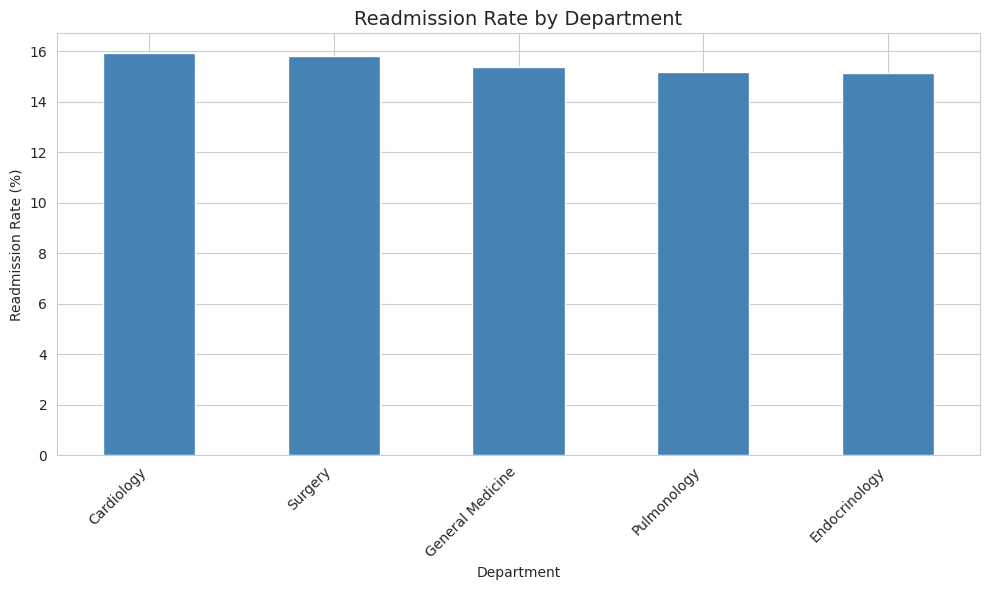

In [ ]:
dept_readmit = df.groupby('Department')['Readmitted'].mean().sort_values(ascending=False) * 100

print("Readmission Rate by Department (%):")
print(dept_readmit)

import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
dept_readmit.plot(kind='bar', color='steelblue')
plt.title('Readmission Rate by Department', fontsize=14)
plt.ylabel('Readmission Rate (%)')
plt.xlabel('Department')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd, numpy as np, os, sys, matplotlib.pyplot as plt, seaborn as sns
path = "/content/hospital - hospital.csv"
print("File exists:", os.path.exists(path))
df = pd.read_csv(path)
print("Shape:", df.shape)
print("\nColumns:\n", df.columns.tolist())
print("\nHead (first 5 rows):")
display(df.head())

candidates = [c for c in df.columns if any(k in c.lower() for k in ["day","time","date","interval","to_readmit","timeto","days","since","readmit_day"])]
print("\nPotential time/date-related columns:", candidates)

if 'Readmitted' in df.columns:
    print("\nReadmitted value counts:\n", df['Readmitted'].value_counts(dropna=False))
else:
    print("\nNo 'Readmitted' column found.")

print("\nDtypes and null counts for key columns:")
key_cols = ['admission_date','discharge_date','Readmitted','DaysToReadmission','Days_To_Readmit','TimeToReadmit']
for c in key_cols:
    if c in df.columns:
        print(c, df[c].dtype, "nulls:", df[c].isnull().sum())

date_like = [c for c in df.columns if df[c].dtype == object and df[c].str.match(r'\d{4}-\d{2}-\d{2}', na=False).any()]
print("\nColumns with ISO date-like strings (sample):", date_like)

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print("\nNumeric columns (sample 30):", numeric_cols[:30])

File exists: True
Shape: (10000, 18)

Columns:
 ['Age', 'Gender', 'Insurance_Type', 'Marital_Status', 'Admission_Type', 'Primary_Diagnosis', 'Department', 'BMI', 'Glucose_Level', 'Comorbidities', 'ICU_Admission', 'Surgery', 'LOS', 'Followup_Scheduled', 'Home_Health_Referral', 'PrevAdm12M', 'ER_Visits', 'Readmitted']

Head (first 5 rows):


,Age,Gender,Insurance_Type,Marital_Status,Admission_Type,Primary_Diagnosis,Department,BMI,Glucose_Level,Comorbidities,ICU_Admission,Surgery,LOS,Followup_Scheduled,Home_Health_Referral,PrevAdm12M,ER_Visits,Readmitted
0,71,Male,Medicaid,Married,Electve,Pneumonia,Surgery,17.6,107.9,1,1,0,0.9,0.0,0.0,0,2,0
1,34,Female,Medicare,Widowed,Emergency,Heart Failure,General Medicine,28.1,93.4,2,0,0,6.7,1.0,1.0,1,2,1
2,80,Male,Medicaid,Single,Emergency,HeartFailure,General Medicine,28.1,169.1,2,1,1,6.3,0.0,0.0,0,3,0
3,40,Female,Medicare,Single,Elective,Diabetes,Endocrinology,25.7,128.3,0,0,0,1.9,1.0,1.0,1,1,0
4,43,Female,Uninsured,Single,elective,Surgery Recovery,Cardiology,35.2,140.2,1,0,0,3.0,0.0,0.0,2,1,0



Potential time/date-related columns: []

Readmitted value counts:
 Readmitted
0    8453
1    1547
Name: count, dtype: int64

Dtypes and null counts for key columns:
Readmitted int64 nulls: 0

Columns with ISO date-like strings (sample): []

Numeric columns (sample 30): ['Age', 'BMI', 'Glucose_Level', 'Comorbidities', 'ICU_Admission', 'Surgery', 'LOS', 'Followup_Scheduled', 'Home_Health_Referral', 'PrevAdm12M', 'ER_Visits', 'Readmitted']


Loaded: (10000, 18)
Columns: ['Age', 'Gender', 'Insurance_Type', 'Marital_Status', 'Admission_Type', 'Primary_Diagnosis', 'Department', 'BMI', 'Glucose_Level', 'Comorbidities', 'ICU_Admission', 'Surgery', 'LOS', 'Followup_Scheduled', 'Home_Health_Referral', 'PrevAdm12M', 'ER_Visits', 'Readmitted']

Readmitted distribution:
Readmitted
0    8453
1    1547
Name: count, dtype: int64

Feature matrix shape after encoding: (10000, 33)
Train/Test sizes: (8000, 33) (2000, 33)
XGBoost trained

LogisticRegression -- AUC: 0.6739, AUPRC: 0.2679

RandomForest -- AUC: 0.6574, AUPRC: 0.2467

XGBoost -- AUC: 0.6070, AUPRC: 0.2065

Ensemble_RF_XGB -- AUC: 0.6419, AUPRC: 0.2217

SHAP is available. Computing SHAP values for tree model...
Saved shap_summary.png
Saved km_overall.png
Saved km_by_dept.png

Model performance summary (AUC / AUPRC):
 - LogisticRegression: AUC=0.6739, AUPRC=0.2679
 - RandomForest: AUC=0.6574, AUPRC=0.2467
 - XGBoost: AUC=0.6070, AUPRC=0.2065
 - Ensemble_RF_XGB: AUC=0.6419, AUPRC=

{'models': {'LogisticRegression': LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
  'RandomForest': RandomForestClassifier(class_weight='balanced', n_estimators=200, n_jobs=-1,
                         random_state=42),
  'XGBoost': XGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bynode=None,
                colsample_bytree=None, device=None, early_stopping_rounds=None,
                enable_categorical=False, eval_metric='auc', feature_types=None,
                feature_weights=None, gamma=None, grow_policy=None,
                importance_type=None, interaction_constraints=None,
                learning_rate=None, max_bin=None, max_cat_threshold=None,
                max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
                max_leaves=None, min_child_weight=None, missing=nan,
                monotone_constraints=None, multi_strategy=None, n_estimators=None,
              

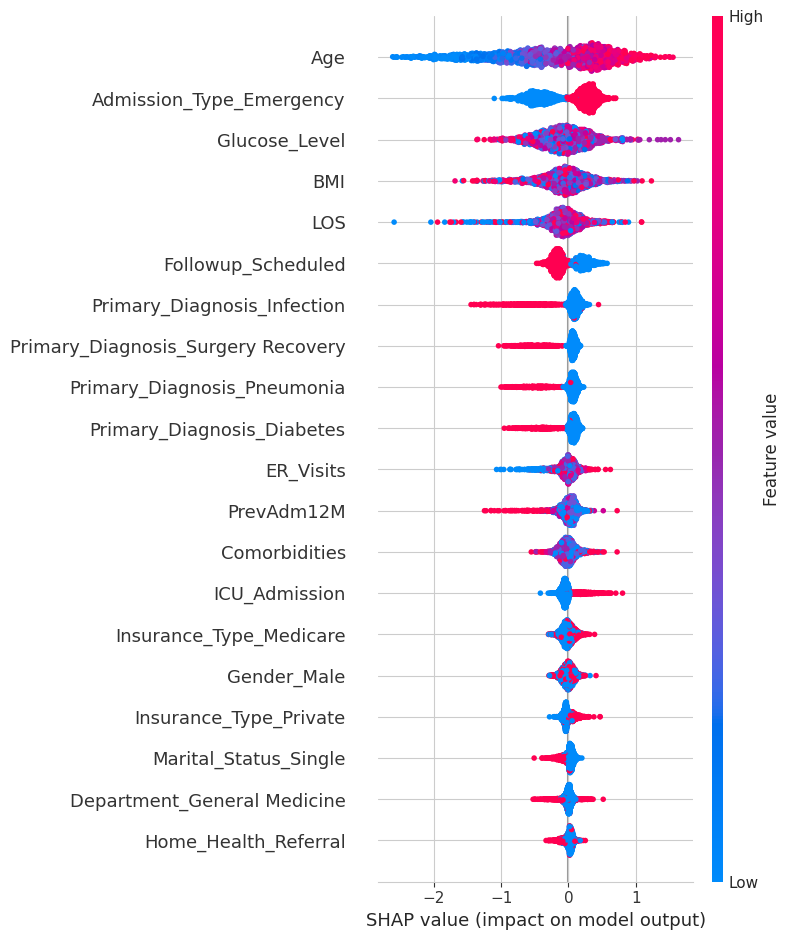

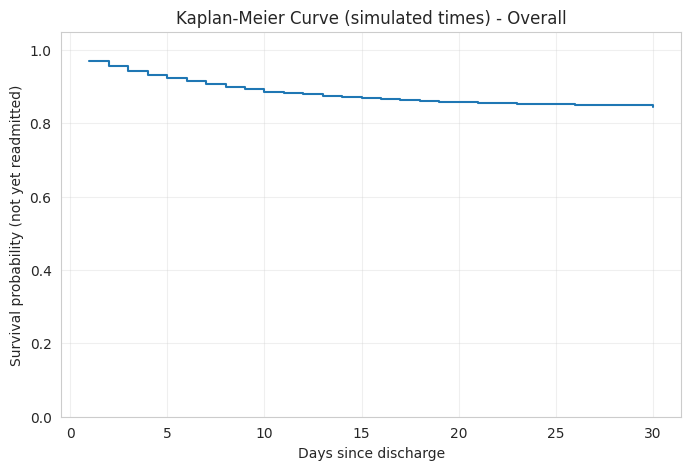

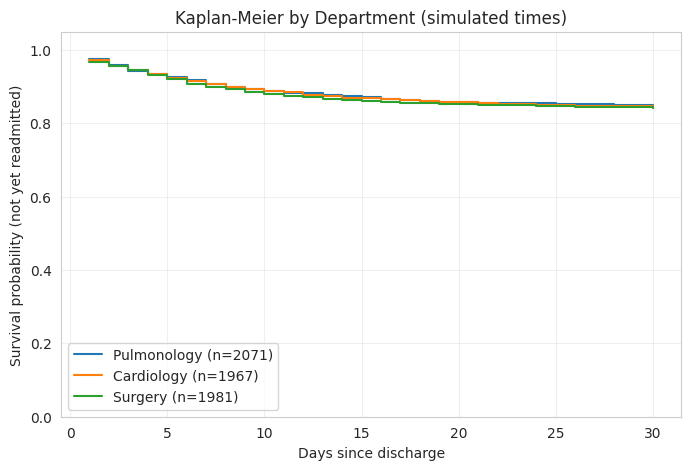

In [ ]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, sys, os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, precision_recall_curve, classification_report
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import resample
import warnings
warnings.filterwarnings("ignore")

path = "/content/hospital - hospital.csv"
df = pd.read_csv(path)
print("Loaded:", df.shape)
print("Columns:", df.columns.tolist())

print("\nReadmitted distribution:")
print(df['Readmitted'].value_counts())

feature_cols = [
    'Age','BMI','Glucose_Level','Comorbidities','ICU_Admission','Surgery',
    'LOS','PrevAdm12M','ER_Visits','Followup_Scheduled','Home_Health_Referral'
]
cat_cols = ['Gender','Insurance_Type','Marital_Status','Admission_Type','Department','Primary_Diagnosis']

feature_cols = [c for c in feature_cols if c in df.columns]
cat_cols = [c for c in cat_cols if c in df.columns]

X_num = df[feature_cols].copy()
X_cat = df[cat_cols].copy()

X_num = X_num.replace([np.inf, -np.inf], np.nan)

imp = SimpleImputer(strategy='median')
X_num_imp = pd.DataFrame(imp.fit_transform(X_num), columns=X_num.columns, index=X_num.index)

X_cat_ohe = pd.get_dummies(X_cat, drop_first=True)

X = pd.concat([X_num_imp, X_cat_ohe], axis=1)
y = df['Readmitted']

print("\nFeature matrix shape after encoding:", X.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("Train/Test sizes:", X_train.shape, X_test.shape)

X_train = X_train.replace([np.inf, -np.inf], np.nan).fillna(0)
X_test = X_test.replace([np.inf, -np.inf], np.nan).fillna(0)

num_cols = X_num_imp.columns.tolist()
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

models = {}
lr = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
lr.fit(X_train, y_train)
models['LogisticRegression'] = lr

rf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced', n_jobs=-1)
rf.fit(X_train, y_train)
models['RandomForest'] = rf

try:
    from xgboost import XGBClassifier
    xgb = XGBClassifier(use_label_encoder=False, eval_metric='auc', random_state=42, n_jobs= -1)
    xgb.fit(X_train, y_train)
    models['XGBoost'] = xgb
    xgb_available = True
    print("XGBoost trained")
except Exception as e:
    print("XGBoost not available or failed to train:", e)
    xgb_available = False

results = {}
for name, m in models.items():
    if name == 'LogisticRegression':
        pred = m.predict_proba(X_test)[:,1]
    else:
        pred = m.predict_proba(X_test)[:,1]
    auc = roc_auc_score(y_test, pred)
    auprc = average_precision_score(y_test, pred)
    results[name] = {'AUC':auc, 'AUPRC':auprc, 'pred': pred}
    print(f"\n{name} -- AUC: {auc:.4f}, AUPRC: {auprc:.4f}")

if 'XGBoost' in models:
    ens_pred = 0.5 * results['RandomForest']['pred'] + 0.5 * results['XGBoost']['pred']
    ens_name = 'Ensemble_RF_XGB'
else:
    ens_pred = 0.5 * results['RandomForest']['pred'] + 0.5 * results['LogisticRegression']['pred']
    ens_name = 'Ensemble_RF_LR'
ens_auc = roc_auc_score(y_test, ens_pred)
ens_auprc = average_precision_score(y_test, ens_pred)
results[ens_name] = {'AUC':ens_auc, 'AUPRC':ens_auprc, 'pred': ens_pred}
print(f"\n{ens_name} -- AUC: {ens_auc:.4f}, AUPRC: {ens_auprc:.4f}")

shap_available = False
try:
    import shap
    shap_available = True
    print("\nSHAP is available. Computing SHAP values for tree model...")
    tree_model = models.get('XGBoost', models.get('RandomForest'))
    expl = shap.TreeExplainer(tree_model)
    shap_values = expl.shap_values(X_test)
    shap.summary_plot(shap_values, X_test, show=False)
    plt.tight_layout()
    plt.savefig('shap_summary.png', dpi=200, bbox_inches='tight')
    print("Saved shap_summary.png")
except Exception as e:
    print("SHAP not available or failed:", e)
    shap_available = False

np.random.seed(42)
n = len(df)
times = np.full(n, 30, dtype=float)
events = df['Readmitted'].values.astype(int)
readmit_idx = np.where(events == 1)[0]
sim_days = np.random.exponential(scale=8, size=len(readmit_idx))
sim_days = np.clip(np.round(sim_days).astype(int), 1, 30)
times[readmit_idx] = sim_days

surv_df = pd.DataFrame({'time': times, 'event': events, 'Department': df['Department']})

def kaplan_meier(times, events):
    data = pd.DataFrame({'time': times, 'event': events}).sort_values('time')
    times_unique = np.sort(np.unique(data['time']))
    n_at_risk = []
    n_events = []
    survival = []
    n = len(data)
    s = 1.0
    for t in times_unique:
        at_risk = (data['time'] >= t).sum()
        d = ((data['time'] == t) & (data['event'] == 1)).sum()
        if at_risk > 0:
            s *= (1 - d / at_risk)
        n_at_risk.append(at_risk)
        n_events.append(d)
        survival.append(s)
    return pd.DataFrame({'time': times_unique, 'at_risk': n_at_risk, 'events': n_events, 'survival': survival})

km_overall = kaplan_meier(surv_df['time'].values, surv_df['event'].values)
plt.figure(figsize=(8,5))
plt.step(km_overall['time'], km_overall['survival'], where='post')
plt.ylim(0,1.05)
plt.xlabel('Days since discharge')
plt.ylabel('Survival probability (not yet readmitted)')
plt.title('Kaplan-Meier Curve (simulated times) - Overall')
plt.grid(alpha=0.3)
plt.savefig('km_overall.png', dpi=200, bbox_inches='tight')
print("Saved km_overall.png")

dept_counts = df.groupby('Department')['Readmitted'].sum().sort_values(ascending=False)
top3 = dept_counts.head(3).index.tolist()
plt.figure(figsize=(8,5))
for dept in top3:
    sub = surv_df[surv_df['Department'] == dept]
    km_sub = kaplan_meier(sub['time'].values, sub['event'].values)
    plt.step(km_sub['time'], km_sub['survival'], where='post', label=f"{dept} (n={len(sub)})")
plt.legend()
plt.ylim(0,1.05)
plt.xlabel('Days since discharge')
plt.ylabel('Survival probability (not yet readmitted)')
plt.title('Kaplan-Meier by Department (simulated times)')
plt.grid(alpha=0.3)
plt.savefig('km_by_dept.png', dpi=200, bbox_inches='tight')
print("Saved km_by_dept.png")

print("\nModel performance summary (AUC / AUPRC):")
for k,v in results.items():
    print(f" - {k}: AUC={v['AUC']:.4f}, AUPRC={v['AUPRC']:.4f}")
print(f" - {ens_name}: AUC={ens_auc:.4f}, AUPRC={ens_auprc:.4f}")

importances = pd.Series(models['RandomForest'].feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nTop 15 RandomForest feature importances:\n", importances.head(15))

print("\nSaved plots: shap_summary.png (if SHAP ran), km_overall.png, km_by_dept.png")

result = {
    'models': models,
    'results': results,
    'ensemble_name': ens_name,
    'ensemble_pred': ens_pred,
    'feature_importances': importances,
    'shap_available': shap_available
}
result

In [ ]:
import pandas as pd

df = pd.read_csv('/content/hospital - hospital.csv')

readmission_rate = df['Readmitted'].mean()

readmission_rate_percent = readmission_rate * 100

print(f"Readmission rate: {readmission_rate:.4f} ({readmission_rate_percent:.2f}%)")

Readmission rate: 0.1547 (15.47%)


In [ ]:
if 'df' not in locals():
    try:
        df = pd.read_csv("/content/hospital - hospital.csv")
        print("DataFrame loaded.")
    except FileNotFoundError:
        print("Error: hospital - hospital.csv not found. Please load your data.")
        df = None

if df is not None and 'Primary_Diagnosis' in df.columns and 'Readmitted' in df.columns:
    df_temp = df.copy()
    df_temp['Primary_Diagnosis'] = df_temp['Primary_Diagnosis'].str.lower()
    df_temp['Primary_Diagnosis'] = df_temp['Primary_Diagnosis'].replace('heartfailure', 'heart failure')

    diag_readmit_rate = df_temp.groupby('Primary_Diagnosis')['Readmitted'].mean().sort_values(ascending=False) * 100

    top_5_diagnoses = diag_readmit_rate.head(5);

    print("\nTop 5 Diagnoses by Readmission Rate (%):")
    print(top_5_diagnoses)
else:
    print("Required columns ('Primary_Diagnosis', 'Readmitted') or DataFrame not found.")


📊 Top 5 Diagnoses by Readmission Rate (%):
Primary_Diagnosis
heart failure       22.321429
copd                19.297235
diabetes            13.165952
pneumonia           13.043478
surgery recovery    12.701363
Name: Readmitted, dtype: float64


In [ ]:
over_50_df = df[df['Age'] > 50].copy()

readmission_rate_over_50 = over_50_df['Readmitted'].mean()

print(f"Readmission Rate for patients over 50: {readmission_rate_over_50:.2%}")

Readmission Rate for patients over 50: 20.37%


In [ ]:
if 'age_bins' not in locals():
    if 'Age' in df.columns:
        age_bins = pd.cut(df['Age'], bins=[0,30,50,70,90,120], labels=['<30','31-50','51-70','71-90','90+'])
    else:
        print("Age column not found in DataFrame.")
        age_bins = None

if age_bins is not None:
    age_readmission_counts = df.groupby([age_bins, 'Readmitted']).size().unstack(fill_value=0)

    age_readmission_counts.columns = ['Not Readmitted', 'Readmitted']

    print("Readmission Counts by Age Group:")
    display(age_readmission_counts)

Readmission Counts by Age Group:


,Not Readmitted,Readmitted
Age,,
<30,1409,106
31-50,2627,311
51-70,2300,499
71-90,2112,631
90+,5,0


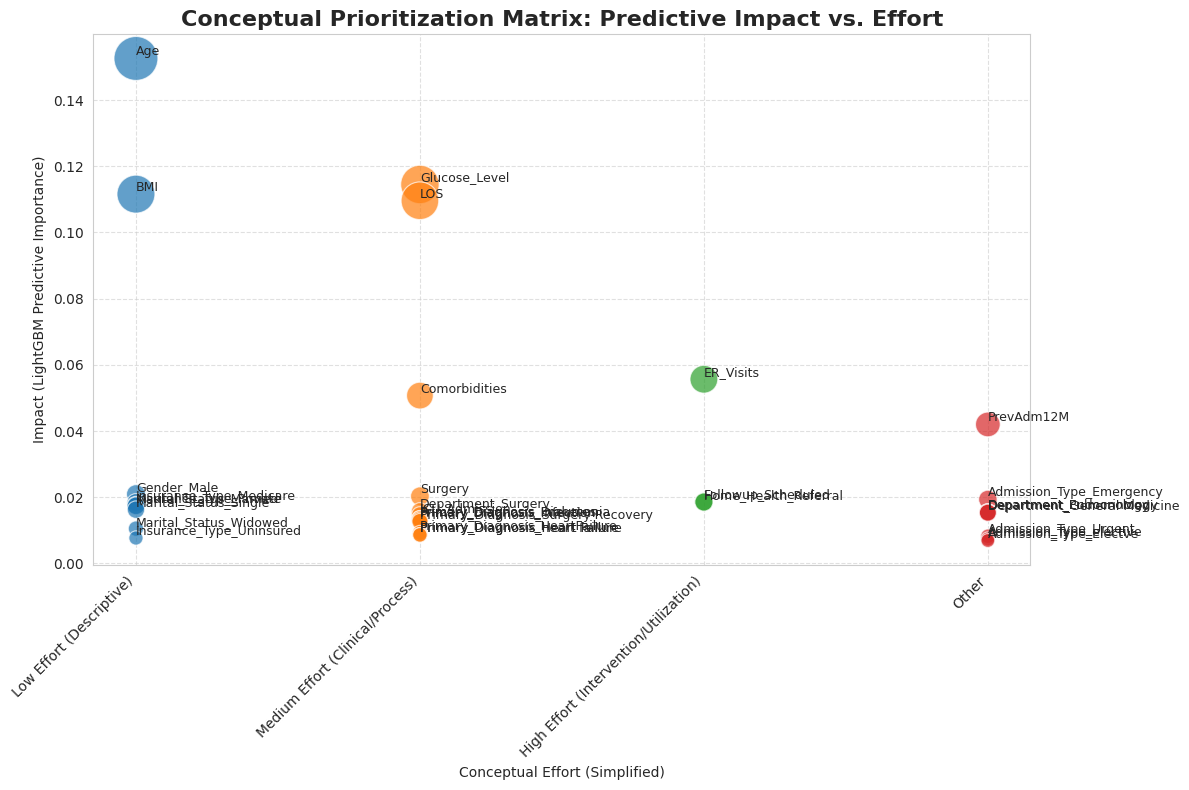

In [ ]:
if 'importances' in locals():
    feature_impact = importances.reset_index()
    feature_impact.columns = ['Feature', 'Impact (Predictive Importance)']

    def assign_effort(feature_name):
        name_lower = feature_name.lower()
        if any(keyword in name_lower for keyword in ['age', 'gender', 'marital', 'insurance', 'bmi']):
            return 'Low Effort (Descriptive)'
        elif any(keyword in name_lower for keyword in ['comorbid', 'diagnosis', 'glucose', 'los', 'icu', 'surgery']):
            return 'Medium Effort (Clinical/Process)'
        elif any(keyword in name_lower for keyword in ['followup', 'home_health', 'prev_adm', 'er_visits', 'discharge_planning', 'risk_score', 'utilizer', 'vulnerable']):
             return 'High Effort (Intervention/Utilization)'
        else:
            return 'Other'

    feature_impact['Conceptual Effort'] = feature_impact['Feature'].apply(assign_effort)

    feature_impact = feature_impact.sort_values('Impact (Predictive Importance)', ascending=False)

    plt.figure(figsize=(12, 8))
    scatter = sns.scatterplot(
        data=feature_impact,
        x='Conceptual Effort',
        y='Impact (Predictive Importance)',
        hue='Conceptual Effort',
        size='Impact (Predictive Importance)',
        sizes=(100, 1000),
        alpha=0.7,
        legend=False
    )

    plt.title('Conceptual Prioritization Matrix: Predictive Impact vs. Effort', fontsize=16, weight='bold')
    plt.xlabel('Conceptual Effort (Simplified)')
    plt.ylabel('Impact (LightGBM Predictive Importance)')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xticks(rotation=45, ha='right')

    for i in range(len(feature_impact)):
        plt.text(
            feature_impact['Conceptual Effort'].iloc[i],
            feature_impact['Impact (Predictive Importance)'].iloc[i],
            feature_impact['Feature'].iloc[i],
            fontsize=9,
            ha='left',
            va='bottom'
        )

    plt.tight_layout()
    plt.show()

else:
    print("LightGBM feature importances ('importances' variable) not found. Please run cell v3Y2HjMxz0f2 first.")